In [340]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import simps
from scipy.interpolate import interp1d
from glob import glob
import pandas as pd
import astropy.units as u

from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [341]:
x = lambda Egamma, Mbh : Egamma / (1058 * 1e10 / Mbh)

# parameterization in Eq . (31 - 34) of 1510.04372, all in GeV^-1 sec^-1
A = 6.339 * 1e23
B = 1.1367 * 1e24
thetaS = lambda u : .5 * (1 + np.tanh(10 * u))

def frag(Egamma, Mbh):
    return (
        A * x(Egamma, Mbh)**(-3/2) * ( 1 - thetaS( x(Egamma, Mbh) - 0.3 ) ) + 
        B * np.exp( -x(Egamma, Mbh) ) * thetaS( x(Egamma, Mbh) - 0.3 ) / ( x(Egamma, Mbh) * ( x(Egamma, Mbh) + 1 ) ) 
    )

def Ffunc(y):
    val = np.exp( -.0962 - 1.982 * (np.log(y) - 1.908) * (1 + np.tanh(20 * (np.log(y) - 1.908)) ))
    val[np.where(y <= 2)] = 1
    return val

def dir(Egamma, Mbh):
    return (
        1.13 * 1e19 * x(Egamma, Mbh)**6 / ( (np.exp(x(Egamma, Mbh)) - 1) * Ffunc(x(Egamma, Mbh)) )
    )

Mbh = lambda time : 1e10 * (time/407)**(1/3)

parameter_photon_flux = lambda time, Egamma: dir(Egamma, Mbh(time)) + frag(Egamma, Mbh(time))
parameter_photon_flux_mass = lambda mass, Egamma: dir(Egamma, mass) + frag(Egamma, mass)

0.0001058
1.058
1058.0


/Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: overflow encountered in exp
/Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: overflow encountered in exp
/Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: overflow encountered in exp
/Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: overflow encountered in exp
/Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: overflow encountered in exp
/Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: overflow encountered in exp


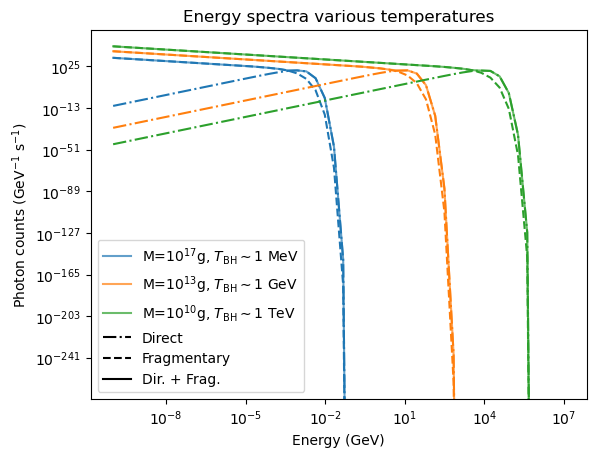

In [342]:
Tbh_mass = lambda Mbh : 1.058 * 1e13 / Mbh

print(Tbh_mass(1e17))
print(Tbh_mass(1e13))
print(Tbh_mass(1e10))

fig, ax = plt.subplots()

E = np.logspace(-10, 7)

# M in g, Temp in GeV
temp_from_mass = lambda M: 1.06 * (1e13 / M) # GeV

# plt.loglog( E, dir(E,1e20) + frag(E,1e20), '-', color = 'C0', label = r'M=$10^{20}$' )

ax.loglog( E, dir(E,1e17) + frag(E,1e17), '-', color='C0', alpha = .7, label = r'M=$10^{17}$g, $T_{\rm{BH}}\sim$1 MeV')
ax.loglog( E, dir(E,1e17), '-.', color='C0')
ax.loglog( E, frag(E,1e17), '--', color='C0')

# plt.axvline(temp_from_mass(1e14), linestyle='--', color = 'C0', label = r'$T_{BH}=$%s GeV'%(temp_from_mass(1e14)))

# plt.loglog( E, dir(E,1e12), '--', color='C0', label = r'Dir M=$10^{12}$' )
# plt.loglog( E, frag(E,1e12), '--', color='C0', label = r'Frag M=$10^{12}$' )

ax.loglog( E, dir(E,1e13) + frag(E,1e13), '-', color = 'C1', alpha = .7, label = r'M=$10^{13}$g, $T_{\rm{BH}}\sim$1 GeV')
ax.loglog( E, dir(E,1e13), '-.', color='C1')
ax.loglog( E, frag(E,1e13), '--', color='C1')
# plt.axvline(temp_from_mass(1e6), linestyle='--', color = 'C1', label = r'$T_{BH}=$%s GeV'%(temp_from_mass(1e6)))
# plt.loglog( E, dir(E,1e6), '--', color = 'C1', label = r'Dir M=$10^6$' )
# plt.loglog( E, frag(E,1e6), '--', color = 'C1', label = r'Frag M=$10^6$' )


ax.loglog( E, dir(E,1e10) + frag(E,1e10), '-', color = 'C2', alpha = .7, label = r'M=$10^{10}$g, $T_{\rm{BH}}\sim$1 TeV')
ax.loglog( E, dir(E,1e10), '-.', color='C2')
ax.loglog( E, frag(E,1e10), '--', color='C2')

ax.loglog(0,0, '-.', color = 'black', label = 'Direct')
ax.loglog(0,0, '--', color = 'black', label = 'Fragmentary')
ax.loglog(0,0, '-', color = 'black', label = 'Dir. + Frag.')

ax.legend()

# plt.loglog(E, 1e33*E**(-1.5))

ax.set_title(r'Energy spectra various temperatures')

ax.set_xlabel('Energy (GeV)')
ax.set_ylabel(r'Photon counts (GeV$^{-1}$ s$^{-1}$)')
fig.savefig('EnergySpectrumVaryingTemp.png')

/Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: overflow encountered in exp
/Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in true_divide
/Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/scipy/integrate/_quadrature.py:497: RuntimeWarning: invalid value encountered in double_scalars
  result = result + val


Text(0, 0.5, 'Photon counts (s$^{-1}$)')

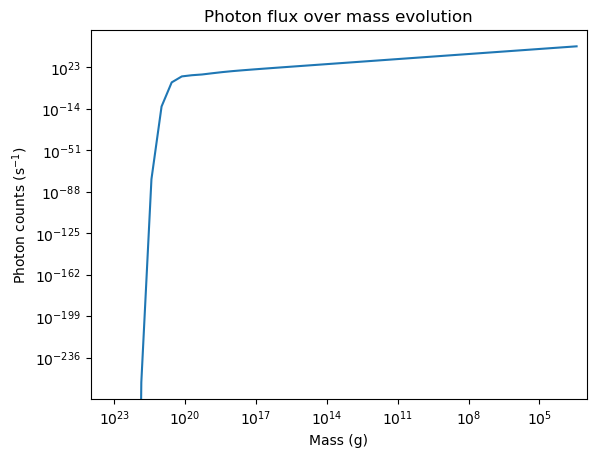

In [343]:
Emin = 1e-6
Emax = 1e11
Erange = np.logspace(-6, 11)

fluxdt = [ simps(parameter_photon_flux_mass(Erange, mass), x = Erange ) for mass in np.logspace(24, 3) ]

plt.loglog(np.logspace(24, 3), fluxdt, label = r'$\frac{d\Phi}{dt}$')

plt.xlim(1e24,1e3)
plt.title('Photon flux over mass evolution')
plt.xlabel('Mass (g)')
plt.ylabel(r'Photon counts (s$^{-1}$)')

/Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: overflow encountered in exp
/Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


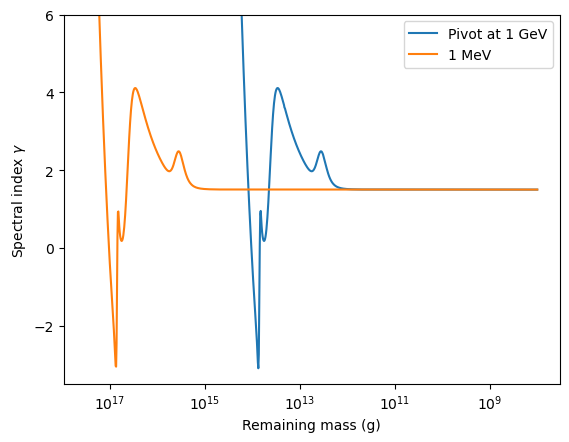

In [344]:
fig, ax = plt.subplots()

gamma = lambda E1,E2, t : (np.log(parameter_photon_flux_mass(np.array([E1]),t)[0]) - np.log(parameter_photon_flux_mass(np.array([E2]),t)[0])) / (np.log(E2)-np.log(E1))

E1, E2 = (1.01, 0.99)
index_evolution = [gamma(E1,E2, m) for m in np.logspace(8, 18, 1000)]
ax.plot(np.logspace(8, 18, 1000), index_evolution, label = 'Pivot at 1 GeV')

E1, E2 = (1.01*1e-3, 0.99*1e-3)
index_evolution = [gamma(E1,E2, m) for m in np.logspace(8, 17.5, 1000)]
ax.plot(np.logspace(8, 17.5, 1000), index_evolution, label = '1 MeV')

ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[1], ax.get_xlim()[0])
ax.set_ylim(-3.5, 6)
ax.set_xlabel(r'Remaining mass (g)')
ax.set_ylabel(r'Spectral index $\gamma$')
ax.legend()
fig.savefig('SpectralIndexvsTau.png')

In [97]:
EffectiveAreas = {
    detector[:-4].split('/')[-1] : 
    pd.read_csv(detector, sep=' ', header=None, names = ['E GeV', 'Aeff cm2'])
    for detector in glob('./EffectiveAreas/*')
    }
del EffectiveAreas['propermotion']


def N_S(Egamma:list, time, Aeff, distance):
    fluxdt = [ simps( photon_flux(Egamma, t) * Aeff(Egamma) / (4*3.14159 * distance**2), x = Egamma) for t in list(time) ]
    return fluxdt

instantaneous_N_S = lambda Egamma, time, Aeff, distance : simps( photon_flux(Egamma, time) * Aeff(Egamma), x = Egamma) / (4*3.14159 * distance**2)

Text(0.5, 1.0, 'Effective areas of detectors')

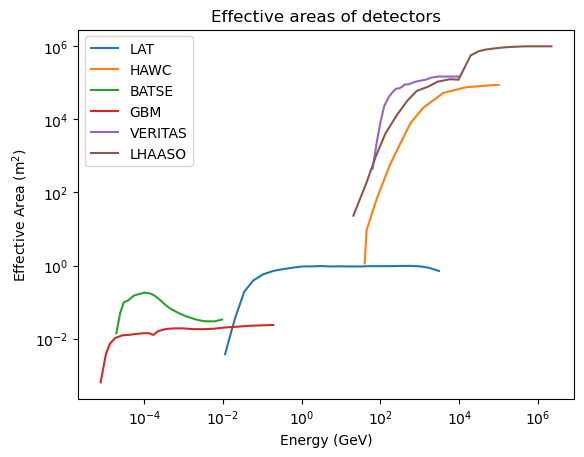

In [98]:
fig, ax = plt.subplots()

for Aeff in EffectiveAreas:
    E = EffectiveAreas[Aeff]['E GeV']
    ax.loglog(E, interp1d(x = E, y = EffectiveAreas[Aeff]['Aeff cm2'] * (u.cm.to('m'))**2, kind='linear', bounds_error = False, fill_value = 0.)(E), label = Aeff)

ax.legend()
ax.set_xlabel('Energy (GeV)')
ax.set_ylabel('Effective Area (m$^2$)')
ax.set_title('Effective areas of detectors')

/Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: overflow encountered in exp
/Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: overflow encountered in exp
/Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: overflow encountered in exp
/Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: overflow encountered in exp
/Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: overflow encountered in exp
/Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: overflow encountered in exp


(1000000000.0, 0.001)

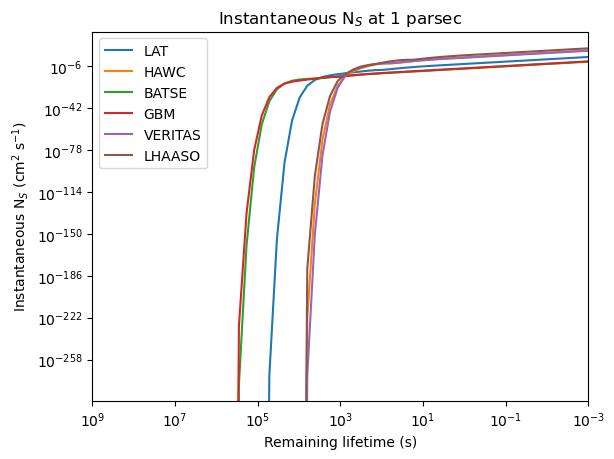

In [99]:
Erange = np.logspace(-6, 7)

for detector in EffectiveAreas:
    Aeff = interp1d( x = EffectiveAreas[detector]['E GeV'], y = EffectiveAreas[detector]['Aeff cm2'], kind='linear', bounds_error = False, fill_value = 0. )

    plt.loglog(np.logspace(-3,6), [instantaneous_N_S( Erange, t, Aeff, 1 * u.pc.to('cm') ) for t in np.logspace(-3, 9)] , label = detector)

plt.legend()
plt.xlabel('Remaining lifetime (s)')
plt.ylabel('Instantaneous N$_S$ (cm$^2$ s$^{-1}$)')
plt.title('Instantaneous N$_S$ at 1 parsec')
plt.xlim(1e9, 1e-3)

/Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: overflow encountered in exp
/Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: overflow encountered in exp
/Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: overflow encountered in exp
/Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: overflow encountered in exp
/Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: overflow encountered in exp
/Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: overflow encountered in exp


Text(0.5, 1.0, 'Maximum distance that $N_S$ > 10 ph (-- incl. d$\\Omega$)')

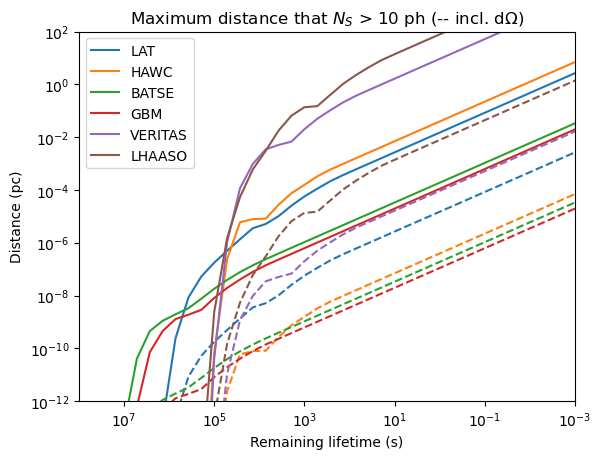

In [100]:
time = np.logspace(9, -5)
distances = np.logspace(-4, 1)

Eranges = { # (Emin, Emax) in log GeV
    'LAT': (-2, 3),
    'GBM': (-4, -2),
    'BATSE': (-5, -2),
    'HAWC': (1, 2),
    'VERITAS': (1, 4),
    'LHAASO': (1,6)
}

dOm = {
    'LAT': 1e-3,
    'GBM': 1e-3,
    'BATSE': 1e-3,
    'HAWC': 1e-5,
    'VERITAS': 1e-5,
    'LHAASO': 1e-4
}

for i,detector in enumerate(EffectiveAreas):
    Erange = np.logspace(Eranges[detector][0], Eranges[detector][1])

    Aeff = interp1d( x = EffectiveAreas[detector]['E GeV'], y = EffectiveAreas[detector]['Aeff cm2'], kind='linear', bounds_error = False, fill_value = 0. )

    det_break = []
    for t in time: 
        # Solve directly for the d contour (set d=1 and then calculate-back d = sqrt( n_s / (4pi * 10) )
        det_break.append( np.sqrt( instantaneous_N_S( Erange, t, Aeff, 1 ) / 10 ) * u.cm.to('pc') )

    det_break = np.array(det_break)

    plt.loglog(time, det_break, color = 'C%s'%i, label = detector)
    plt.loglog(time, det_break * dOm[detector], '--', color = 'C%s'%i)

#plt.axhline(10, linestyle = '--', color = 'black', label = '10 photons')
plt.legend()
plt.xlabel('Remaining lifetime (s)')
plt.ylabel('Distance (pc)')
plt.ylim(1e-12, 1e2)
plt.xlim(1e8, 1e-3)
plt.title('Maximum distance that $N_S$ > 10 ph (-- incl. d$\Omega$)')

In [101]:
Ebkg = lambda E: 1.4*1e-6 * E**(-2.1) #cm-2 GeV-1 s-1 sr-1

def N_B(Egamma, time, Aeff, dOm):
    return time * simps(Aeff(Egamma) * dOm * Ebkg(Egamma), x = Egamma)

/Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: overflow encountered in exp
/Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: overflow encountered in exp
/Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: overflow encountered in exp
/Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: overflow encountered in exp
/Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: overflow encountered in exp
/Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: overflow encountered in exp


Text(0.5, 1.0, '$\\sigma$ signal over background wrt. time, at 1pc')

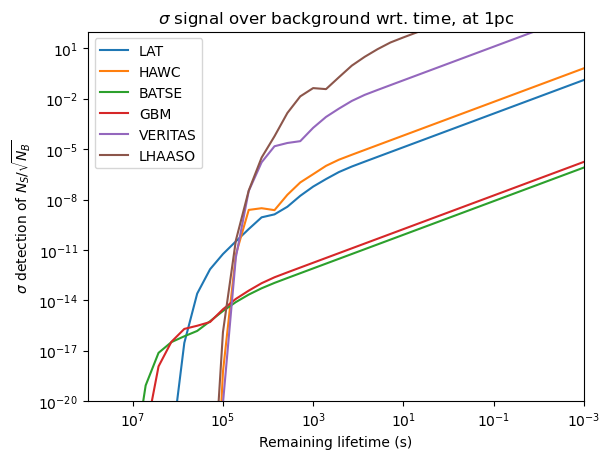

In [102]:
for i,detector in enumerate(EffectiveAreas):
    Erange = np.logspace(Eranges[detector][0], Eranges[detector][1])
    Om = dOm[detector]
    Aeff = interp1d( x = EffectiveAreas[detector]['E GeV'], y = EffectiveAreas[detector]['Aeff cm2'], kind='linear', bounds_error = False, fill_value = 0. )

    signal = time * np.array(N_S(Erange, time, Aeff, 1*u.pc.to('cm'))) * Om
    background = np.array(N_B(Erange, time, Aeff, Om))

    plt.loglog(time, signal/np.sqrt(background), color = 'C%s'%i, label = detector)

#plt.axhline(10, linestyle = '--', color = 'black', label = '10 photons')
plt.legend()
plt.xlabel('Remaining lifetime (s)')
plt.ylabel(r'$\sigma$ detection of $N_S/\sqrt{N_B}$')
plt.xlim(1e8, 1e-3)
plt.ylim(1e-20,1e2)
plt.title('$\sigma$ signal over background wrt. time, at 1pc')

In [103]:
def detN(Egamma, time, Aeff, dOm):
    fluxdt = [ simps(dOm * Aeff(Egamma) * photon_flux(Egamma, t), x = Egamma) for t in time ]
    return simps(fluxdt, x = time)

def detSN(sig, Egamma, Aeff, dOm, tau):
    noise = np.sqrt( min( 3e7, tau ) * simps(dOm * Aeff(Egamma) * Ebkg(Egamma), x = Egamma) )
    return sig/noise

/Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/scipy/integrate/_quadrature.py:372: RuntimeWarning: invalid value encountered in true_divide
  h0divh1 = h0 / h1
/Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/scipy/integrate/_quadrature.py:374: RuntimeWarning: invalid value encountered in true_divide
  y[slice1]*hsum*hsum/hprod +
/Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: overflow encountered in exp
/Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/scipy/integrate/_quadrature.py:372: RuntimeWarning: invalid value encountered in true_divide
  h0divh1 = h0 / h1
/Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/scipy/integrate/_quadrature.py:374: RuntimeWarning: invalid value encountered in true_divide
  y[slice1]*hsum*hsum/hprod +
/Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/ipykernel_launcher.py:21: Runtim

(100000000.0, 0.1)

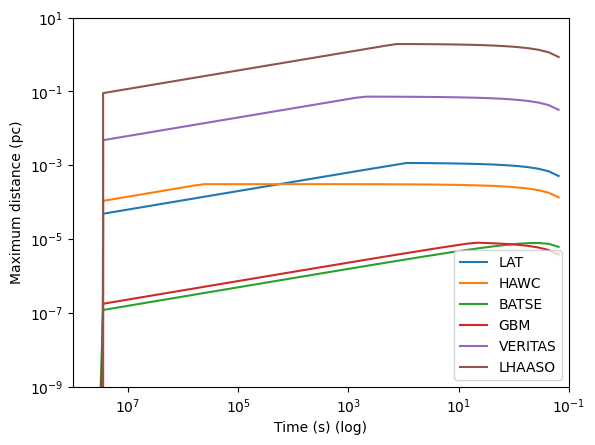

In [104]:
for i,detector in enumerate(EffectiveAreas):
    Erange = np.logspace(Eranges[detector][0], Eranges[detector][1])
    Om = dOm[detector]
    Aeff = interp1d( x = EffectiveAreas[detector]['E GeV'], y = EffectiveAreas[detector]['Aeff cm2'], kind='linear', bounds_error = False, fill_value = 0. )

    remaining_lifetime = np.logspace(-1, 8)

    max_dist = []
    for tau in remaining_lifetime:
        time = np.logspace( np.log10( max(1e-1, tau - 3e7) ), np.log10(tau))
        N = detN(Erange, time, Aeff, Om) / (4 * 3.14159) # let d=1 to just cancel out
        Ns = detSN(N, Erange, Aeff, Om, tau) / (4 * 3.14159)
        max_dist.append( min(
            np.sqrt( N/10 ) * u.cm.to('pc'),
            np.sqrt( Ns/5 ) * u.cm.to('pc'),
                ) )
    
    plt.loglog(remaining_lifetime, max_dist, color = 'C%s'%i, label = detector)

plt.legend()
plt.xlabel('Time (s) (log)')
plt.ylabel('Maximum distance (pc)')
plt.ylim(1e-9, 1e1)
plt.xlim(1e8, 1e-1)
    
    

In [105]:
def logNormalMassFcn(sigma, Mstar, M):
    return np.exp(
        -np.log(M/Mstar)**2 / (2 * sigma**2)
    ) / (np.sqrt(2 * 3.14159) * sigma * M)

fPBH = 1e-8
gramsperGeV = 1 / (5.6095886*1e23)
rhoDM = 0.4 * gramsperGeV * (u.pc.to('cm')**3)

def numberDensity(mass, distance, Mstar = 1e10, sigma = 1):
    return  logNormalMassFcn(sigma, Mstar, mass) * rhoDM * fPBH * 4 / 3 * 3.14159 * distance**3

Text(0.5, 1.0, 'Log PBH number density with log normal mass function')

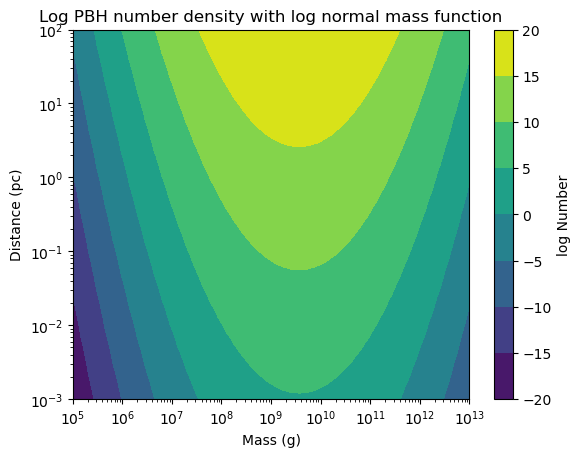

In [106]:
mass = np.logspace(5,13)
distance = np.logspace(-3,2)
M,D = np.meshgrid(mass, distance)

sigma = 1
Mstar = 1e10

plt.contourf( M, D, np.log10(numberDensity(M,D,Mstar,sigma)) )#, levels = [-15, -10, -5, 0, 5, 10, 15] )
cb = plt.colorbar(label = 'log Number')
plt.xlabel('Mass (g)')
plt.ylabel('Distance (pc)')
plt.yscale('log')
plt.xscale('log')
plt.title('Log PBH number density with log normal mass function')

In [107]:
alpha = lambda M: 4 * 1e-4 * M**2

def evolvedMassFunction(sigma, Mstar, M, time):
    return np.exp(
        -np.log( (M**3 + 3*alpha(M) * time)**(1/3) /Mstar)**2 / (2 * sigma**2)
    ) / (np.sqrt(2 * 3.14159) * sigma * (M**3 + 3*alpha(M) * time)**(1/3) * (M**3 / (M**3 + 3*alpha(M) * time)))

def evolvedNumberDensity(mass, distance, Mstar = 1e10, sigma = 1, age_of_universe = 4 * 1e9 * 365 * 24 * 60 * 60):
    return  evolvedMassFunction(sigma, Mstar, mass, age_of_universe) * rhoDM * fPBH * 4 / 3 * 3.14159 * distance**3

Text(0.5, 1.0, 'Log PBH number density with evolved mass function')

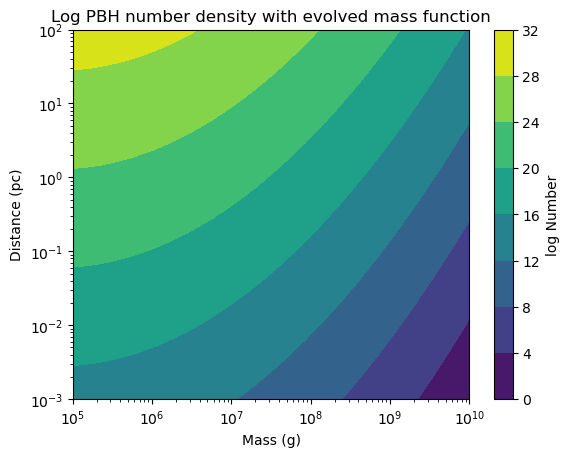

In [108]:
mass = np.logspace(5,10)
distance = np.logspace(-3,2)
M,D = np.meshgrid(mass, distance)

sigma = 1
Mstar = 1e9

plt.contourf( M, D, np.log10(evolvedNumberDensity(M,D,Mstar,sigma)) )#, levels = [-15, -10, -5, 0, 5, 10, 15] )
cb = plt.colorbar(label = 'log Number')
plt.xlabel('Mass (g)')
plt.ylabel('Distance (pc)')
plt.yscale('log')
plt.xscale('log')
plt.title('Log PBH number density with evolved mass function')

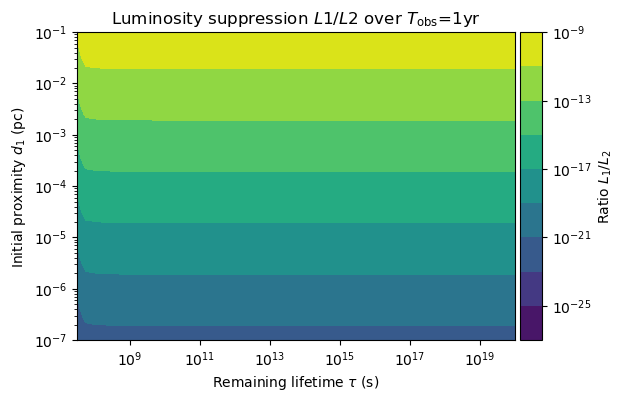

In [210]:
### Change in luminosity plot

# Galactic dispersion
v = (200 * u.km / u.s).to('pc/yr').value
# pg. 23 velocity dispersion of an L⋆ galaxy is σ∥ ≃ 200 km s−1
# pg. 356 quotes ~O(2)
# pg. 646 

luminosity_supp = lambda tau, Tobs = 3e7, d1 = 1e-3, beta = -.3: (tau /(tau - Tobs) )**beta * (d1 / (d1 + v*Tobs))**2

# tau = np.logspace(0,20, 1000)
# mesh = np.zeros((1000,1000))
# for i,Tobs in enumerate(np.logspace(0,np.log10(3e7), 1000)):
#     mesh[i][ np.where(tau[i] <= Tobs) ] = luminosity_supp(tau[i][tau[i] <= Tobs], Tobs = tau[i][tau[i] <= Tobs])
#     mesh[i][ np.where(tau[i] > Tobs) ] = luminosity_supp(tau[i][tau[i] > Tobs], Tobs = 3e7)

# tau, Tobs = np.meshgrid(
#     np.logspace(0,20, 1000),
#     np.logspace(0,np.log10(3e7), 1000)
# )

# fig, ax = plt.subplots()

# divider = make_axes_locatable(ax)
# cax = divider.append_axes('right', size='5%', pad=0.05)

# ct = ax.contourf(Tobs, tau, mesh, norm = LogNorm())

# cb = fig.colorbar(ct, cax = cax)

# ax.set_yscale('log')
# ax.set_xscale('log')
# ax.set_xlabel(r'Observation time $T_{\rm{obs}}$ (s)')
# ax.set_ylabel(r'Remaining lifetime $\tau$ (s)')

tau, d1 = np.meshgrid(
    np.logspace(np.log10(3e7),20),
    np.logspace(-7, -1)
)

fig, ax = plt.subplots(figsize = (6, 4))

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)

lum = luminosity_supp(tau, d1 = d1)

ct = ax.contourf(tau, d1, lum, norm = LogNorm())

cb = fig.colorbar(ct, cax = cax, ticks = [1e-9, 1e-13, 1e-17, 1e-21, 1e-25], label = r'Ratio $L_1 / L_2$')
cb.ax.set_yticklabels( [r'$10^{%.f}$'%np.log10(t) for t in [1e-9, 1e-13, 1e-17, 1e-21, 1e-25]]  )

ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel(r'Remaining lifetime $\tau$ (s)')
ax.set_ylabel(r'Initial proximity $d_1$ (pc) ')
ax.set_title(r'Luminosity suppression $L1/L2$ over $T_{\rm{obs}}$=1yr')

fig.savefig('TransientLuminosity.png')



In [124]:
Mbh = lambda time : 1e10 * (time/407)**(1/3)
tau_mass = lambda Mbh : 407 * (Mbh/1e10)**3

Tbh_mass = lambda Mbh : 1.058 * 1e13 / Mbh
Tbh_tau = lambda tau : 1.058 * 1e13 / Mbh(tau)



def photon_flux(Egamma, Tbh):
    try: 
        assert len(Tbh) > 1, 'Tbh is not vector'
        x = 9*1e35*np.ones((len(Egamma), len(Tbh)))
        for i in range(len(Egamma)):
            for j in range(len(Tbh)):
                x[i,j] *= ( (1/Tbh[j])**1.5 * (1/Egamma[i])**1.5 if Egamma[i] < Tbh[j] else (1/Egamma[i])**3 )
        return x
    except:
        x = 9*1e35*np.ones(len(Egamma))
        for i in range(len(Egamma)):
            x[i] *= ( (1/Tbh)**1.5 * (1/Egamma[i])**1.5 if Egamma[i] < Tbh else (1/Egamma[i])**3 )
        return x

Text(0, 0.5, 'Photon counts (GeV$^{-1}$ s$^{-1}$)')

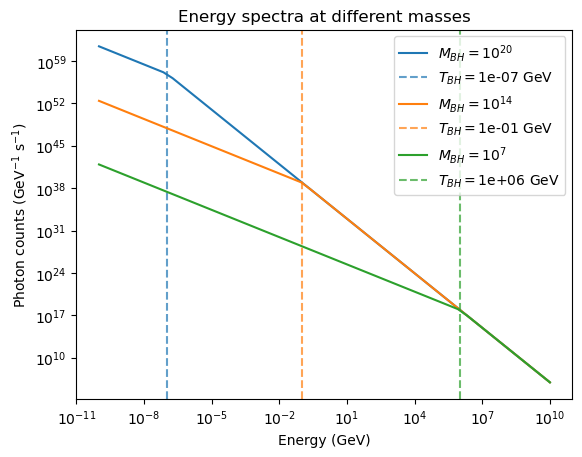

In [110]:
E = np.logspace(-10, 10)

# M in g, Temp in GeV
temp_from_mass = lambda M: 1.06 * (1e13 / M) # GeV

plt.loglog( E, photon_flux(E, Tbh_mass(1e20)), '-', color = 'C0', label = r'$M_{BH}=10^{20}$' )
plt.axvline(temp_from_mass(1e20), linestyle='--', color = 'C0', label = r'$T_{BH}=$%.e GeV'%(temp_from_mass(1e20)), alpha = 0.7)
plt.loglog( E, photon_flux(E, Tbh_mass(1e14)), '-', color='C1', label = r'$M_{BH}=10^{14}$' )
plt.axvline(temp_from_mass(1e14), linestyle='--', color = 'C1', label = r'$T_{BH}=$%.e GeV'%(temp_from_mass(1e14)), alpha = 0.7)
plt.loglog( E, photon_flux(E, Tbh_mass(1e7)), '-', color = 'C2', label = r'$M_{BH}=10^7$' )
plt.axvline(temp_from_mass(1e7), linestyle='--', color = 'C2', label = r'$T_{BH}=$%.e GeV'%(temp_from_mass(1e7)), alpha = 0.7)

plt.legend()

plt.title(r'Energy spectra at different masses')

plt.xlabel('Energy (GeV)')
plt.ylabel(r'Photon counts (GeV$^{-1}$ s$^{-1}$)')

Text(0, 0.5, 'Time-integrated SED (GeV $s^{-1}$)')

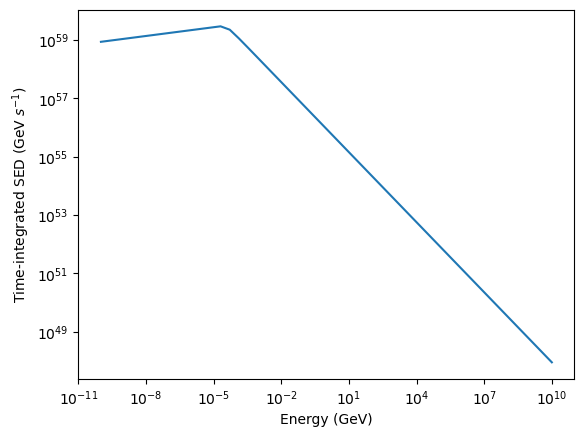

In [87]:
# This doesn't seem right
# Time-integrated energy spectrum
Egamma = np.logspace(-6,6)
tau = np.logspace(0,20)
Tbh = Tbh_tau(tau)

time_int_flux = []
for i in range(len(Egamma)):
    x = 9*1e35*np.ones(len(Tbh))
    for j in range(len(Tbh)):
        x[j] = 9*1e35*( (1/Tbh[j])**1.5 * (1/Egamma[i])**1.5 if Egamma[i] < Tbh[j] else (1/Egamma[i])**3 )
    time_int_flux.append( simps(x=tau, y=x) )

plt.loglog(E, E*np.array(time_int_flux))
plt.xlabel('Energy (GeV)')
plt.ylabel(r'Time-integrated SED (GeV $s^{-1}$)')

In [111]:
Ebkg = lambda E: 1.4*1e-6 * E**(-2.1) #cm-2 GeV-1 s-1 sr-1

gamma_had_sep = {
    'LAT': 0,
    'GBM': 0,
    'BATSE': 0,
    'HAWC': 1e-2,
    'VERITAS': 1e-1,
    'LHAASO': 1e-5
}

def CRbkg(Egamma, frej = 1e-5):
    """frej -> bkg rejection"""
    zz = [1]*len(Egamma)
    for i in range(len(Egamma)):
        zz[i] = max( frej * 1.2*7900*1e-4* Egamma[i]**-2.65,  Ebkg(Egamma[i]))
    return zz

In [112]:
# Proper motion contours
propmo_dat = pd.read_csv('./EffectiveAreas/propermotion.dat', sep=' ', header=None, names = [r'0.1$\circ$ proper motion', r'1$\circ$', r'10$\circ$'])
def log_interp(x,y):
    lin = interp1d(np.log10(x), np.log10(y), kind='linear', fill_value='extrapolate')
    return lambda z: 10**lin(np.log10(z))

In [113]:
year = 365 * 24 * 60 * 60

def detN(Egamma, tau, Aeff, dOm, obs_time, tmin = 1e-1):

    return (obs_time/tau) * simps(dOm * Aeff(Egamma) * photon_flux(Egamma, Tbh_tau(tau)), x = Egamma)

def detSN(sig, Egamma, Aeff, dOm, obs_time, frej):
    noise = np.sqrt( obs_time * simps(dOm * Aeff(Egamma) * CRbkg(Egamma, frej), x = Egamma) )
    return sig/noise

In [ ]:
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)

lum = luminosity_supp(tau, d1 = d1)

ct = ax.contourf(tau, d1, lum, norm = LogNorm())

cb = fig.colorbar(ct, cax = cax, ticks = [1e-9, 1e-13, 1e-17, 1e-21, 1e-25], label = r'Ratio $L_1 / L_2$')
cb.ax.set_yticklabels( [r'$10^{%.f}$'%np.log10(t) for t in [1e-9, 1e-13, 1e-17, 1e-21, 1e-25]]  )

Max dist for LAT: 0.0008433601586678273
Max dist for HAWC: 0.00012401871019678077
Max dist for BATSE: 0.0004200501797608438
Max dist for GBM: 0.00027117248176506694
Max dist for VERITAS: 0.0008202969543244325
Max dist for LHAASO: 0.007726361861924353


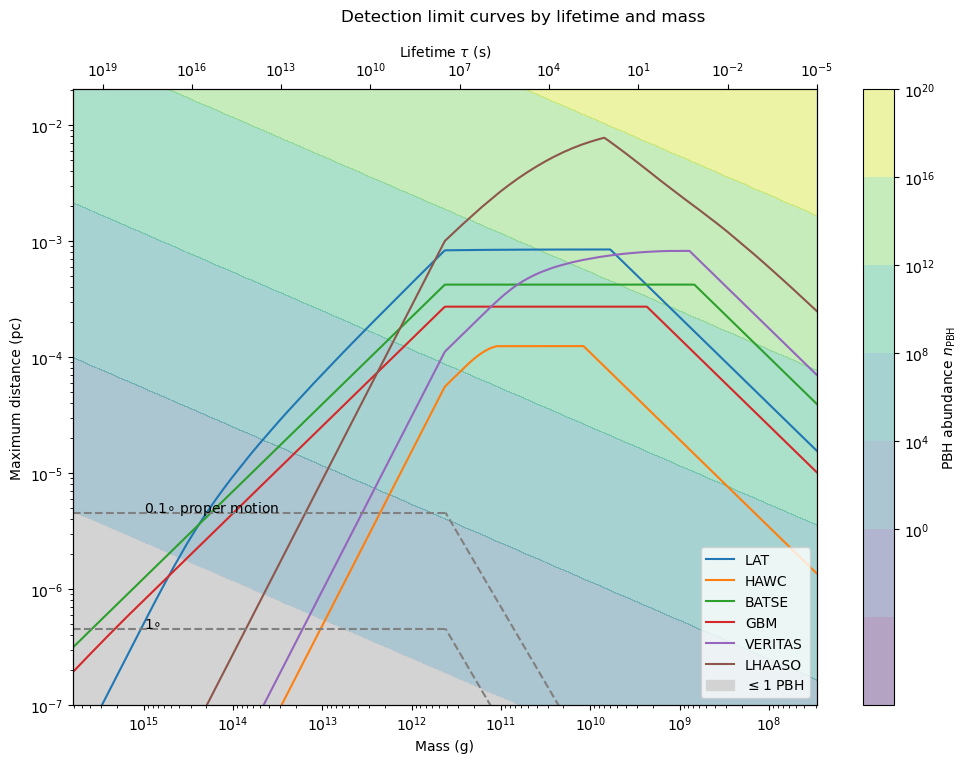

In [811]:
distlim = {}

fig, ax = plt.subplots( figsize = (12,8) )

for i,detector in enumerate(EffectiveAreas):

    # Ranges and interpolation
    Erange = np.logspace(Eranges[detector][0], Eranges[detector][1])
    Om = dOm[detector]
    Aeff = interp1d( x = EffectiveAreas[detector]['E GeV'], y = EffectiveAreas[detector]['Aeff cm2'], kind='linear', bounds_error = False, fill_value = 0. )

    #mass = np.logspace(8, 15, 1_000)
    remaining_lifetime = np.logspace(-5, 20, 1_000)
    tmin = remaining_lifetime[0]

    max_dist = []
    for tau in remaining_lifetime:
        
        # Either obs duration or remaining lifetime
        obs_time = min(year, tau)

        N = detN(Erange, tau, Aeff, Om, obs_time, tmin) / (4 * 3.14159) # let d=1 to just cancel out
        Ns = detSN(N, Erange, Aeff, Om, obs_time, gamma_had_sep[detector]) / (4 * 3.14159)
        max_dist.append( min(
            np.sqrt( N/10 ) * u.cm.to('pc'),
            np.sqrt( Ns/5 ) * u.cm.to('pc'),
                ) )
    
    #ax.loglog(remaining_lifetime, max_dist, color = 'C%s'%i, label = detector)
    mass = Mbh(remaining_lifetime)
    ax.loglog(mass, max_dist, color = 'C%s'%i, label = detector)
    
    print(f'Max dist for {detector}: {max(max_dist)}')
    distlim[detector] = max(max_dist)

    if detector == 'LAT':
        LAT_curve_interp = interp1d(x = remaining_lifetime, y = max_dist, kind='linear', bounds_error = False, fill_value = 'extrapolate' )


# Keep track of axes
ylim = ax.get_ylim()

# Resize for reasonable PBH abundance
ax.set_ylim(*ylim)
ax.set_yticks([1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9, 1e-10])
ax.set_ylim(1e-7, ylim[1])
ylim = ax.get_ylim()

# Show population density

M,D = np.meshgrid(mass, np.logspace(np.log10(ylim[0]), np.log10(ylim[1])))
# sigma = 1
# Mstar = 1e10
# im = ax.contourf( M, D, np.log10(numberDensity(M,D,Mstar,sigma)) , alpha = .4)#, levels = [-15, -10, -5, 0, 5, 10, 15] )
# cb = plt.colorbar(im, label = 'log( number of PBHs )')
monochromatic_npbh = lambda dist, mass, rhoDM=.3, fPBH=1 : rhoDM * fPBH / (mass * 5.62e23) * (4/3*3.14159) * (dist * 3.086e18)**3
im = ax.contourf(M, D, np.log10(monochromatic_npbh(D, M)), alpha = .4)
cb = fig.colorbar(im, label = r'PBH abundance $n_{\rm{PBH}}$', ticks = [20, 16, 12, 8, 4, 0])
cb.ax.set_yticklabels( [r'$10^{%.f}$'%t for t in [20, 16, 12, 8, 4, 0]]  )

# Exclude the <=1PBH realm
v = im.collections[1].get_paths()[0].vertices
ax.fill_between(x = v[:,0], y1 = np.zeros(len(v[:,1])), y2  = v[:,1], label = r'$\leq 1$ PBH', color = 'lightgrey', hatch = '/')
v = im.collections[0].get_paths()[0].vertices
ax.fill_between(x = v[:,0], y1 = np.zeros(len(v[:,1])), y2  = v[:,1], color = 'lightgrey', hatch = '/')

ax.legend(loc='lower right')
#plt.xlabel('Time (s)')
ax.set_xlabel('Mass (g)')
ax.set_ylabel('Maximum distance (pc)')
xlim = ax.get_xlim()
ax.set_xlim(xlim[-1], xlim[0])

# Show proper motion contours
for i in range(2):
    propmo = log_interp(propmo_dat.index, propmo_dat.iloc[:,i])
    ax.loglog([xlim[0], Mbh(3e7)], [propmo(xlim[0]), propmo(Mbh(3e7))], color = 'grey', linestyle = '--')
    ax.plot([Mbh(3e7), xlim[-1]], [propmo(Mbh(3e7)), propmo(Mbh(3e7))], color = 'grey', linestyle = '--')
    ax.text(1e15, propmo(Mbh(3e7)), propmo_dat.columns[i])#, rotation = -60, rotation_mode = 'anchor')

# Add the second axis for lifetime
ax2 = ax.twiny()
ax2.set_xticks(tau_mass(mass))
ax2.set_xscale('log')
ax2.set_xlim(tau_mass(xlim[-1]), tau_mass(xlim[0]))
ax2.set_xlabel(r'Lifetime $\tau$ (s)')


fig.suptitle('Detection limit curves by lifetime and mass')
fig.savefig('Detection_distance_curves.png')

/Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == "":
/Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be se

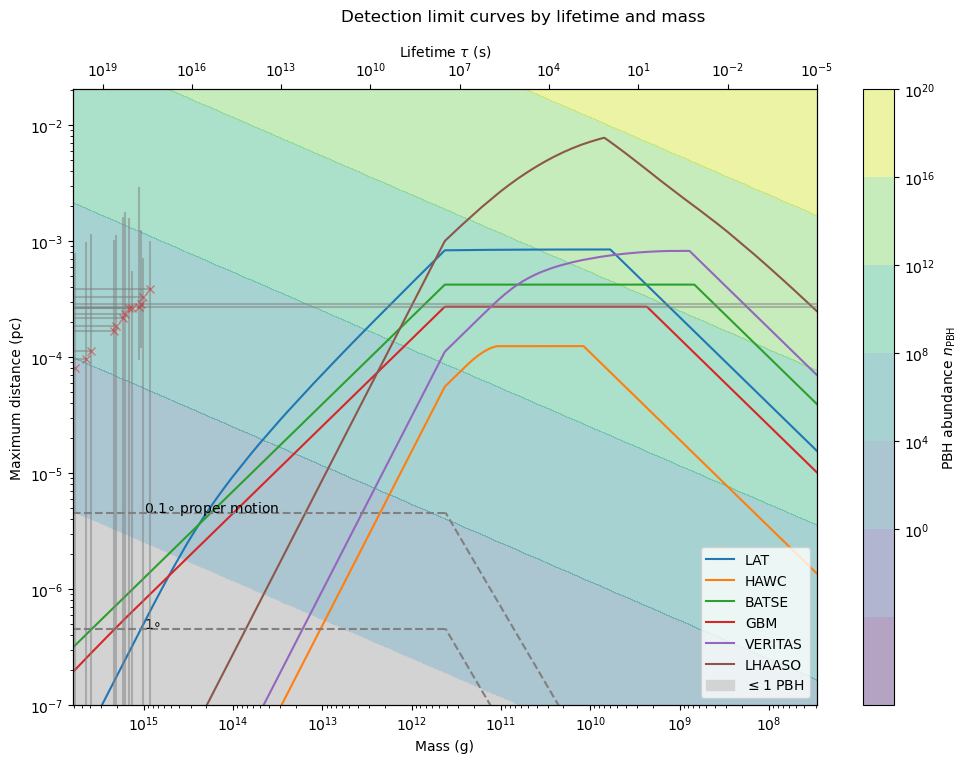

In [812]:
seconds_in_a_day = 8.64e4

##### Transient sources

distance_A = lambda A: np.sqrt(3.2 / A)

# Now show the fitted params overtop the fig
transients = pd.read_csv('../TransientLATSources/TransientSources_fitted_params.csv')#.query('distance<1e-2')

targets = transients.dropna()
targets['T0_lower_error'] = np.abs(T0 - targets['T0_min'])
targets['T0_upper_error'] = np.abs(targets['T0_max'] - T0)
targets['distance_lower_error'] = np.abs(d - targets['dist_max'])
targets['distance_upper_error'] = np.abs(targets['dist_min'] - d)

ax2.errorbar(x = seconds_in_a_day*targets['T0'], xerr = seconds_in_a_day*np.array([ targets['T0_lower_error'], targets['T0_upper_error'] ]),
            y = targets['distance'], yerr = [ targets['distance_lower_error'], targets['distance_upper_error'] ],
            fmt = 'x', color='grey', markeredgecolor = 'C3', alpha=.5, zorder = 1)


fig

In [695]:
selected[['NAME_x', 'PFLX_PLAW_INDEX', 'PFLX_PLAW_INDEX_POS_ERR', 'PFLX_PLAW_INDEX_NEG_ERR']]

,NAME_x,PFLX_PLAW_INDEX,PFLX_PLAW_INDEX_POS_ERR,PFLX_PLAW_INDEX_NEG_ERR
0,b'GRB141205018',-1.492061,0.075433,0.075433
1,b'GRB110520302',-1.531715,0.098269,0.098269
2,b'GRB160326062',-1.561381,0.102787,0.102787
3,b'GRB110818860',-1.454143,0.055156,0.055156
4,b'GRB171004857',-1.569568,0.084473,0.084473
...,...,...,...,...
148,b'GRB170124238',-1.461037,0.042964,0.042964
149,b'GRB131209963',-1.516612,0.075102,0.075102
150,b'GRB180416924',-1.468883,0.041563,0.041563
151,b'GRB141124277',-1.487273,0.179207,0.179207


In [696]:
for i in range(len(selected)):
    t = selected.iloc[i]
    print( f' upper: {t["PFLX_PLAW_INDEX"] + t["PFLX_PLAW_INDEX_POS_ERR"]} lower: {t["PFLX_PLAW_INDEX"] - t["PFLX_PLAW_INDEX_NEG_ERR"]}')

 upper: -1.41662763 lower: -1.5674943700000001
 upper: -1.4334456599999998 lower: -1.62998434
 upper: -1.4585938999999999 lower: -1.6641681
 upper: -1.3989871299999999 lower: -1.50929887
 upper: -1.48509534 lower: -1.6540406600000002
 upper: -1.42140867 lower: -1.55991533
 upper: -1.4378706799999998 lower: -1.52106732
 upper: -1.44890024 lower: -1.6060557599999998
 upper: -1.3616433 lower: -1.6689447
 upper: -1.4115994 lower: -1.6805425999999999
 upper: -1.4815929399999999 lower: -1.61370306
 upper: -1.4881886 lower: -1.7307034
 upper: -1.4970045500000002 lower: -1.69113545
 upper: -1.37101729 lower: -1.5158127099999998
 upper: -1.3726874999999998 lower: -1.5805885
 upper: -1.43982079 lower: -1.58647921
 upper: -1.46961918 lower: -1.51416482
 upper: -1.4570193999999999 lower: -1.7511406
 upper: -1.49657886 lower: -1.67031114
 upper: -1.4908338600000002 lower: -1.66555414
 upper: -1.4328939 lower: -1.7177461
 upper: -1.42132622 lower: -1.53016978
 upper: -1.36263638 lower: -1.52886362
 

/Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: overflow encountered in exp
/Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sy

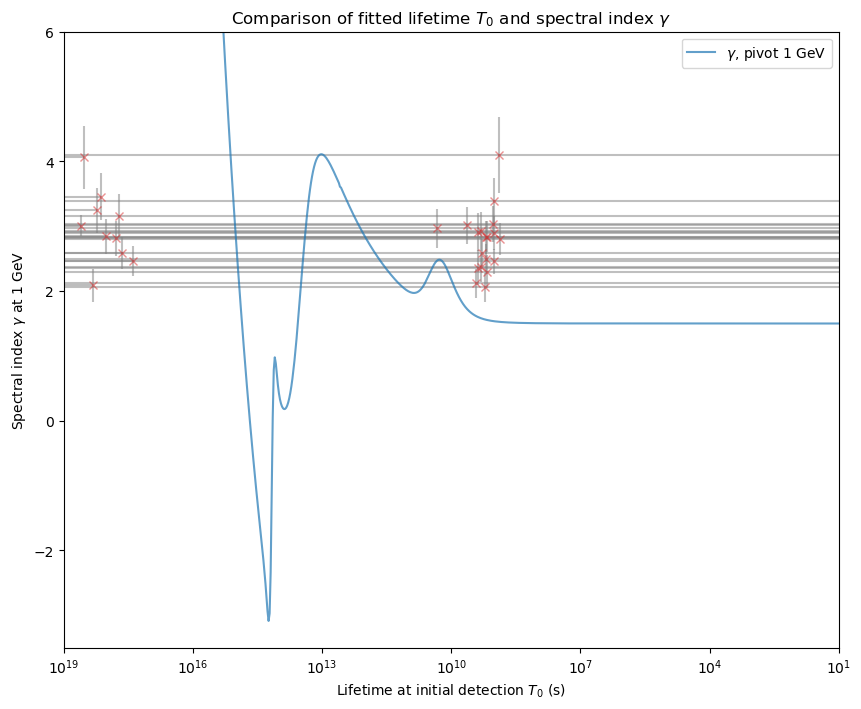

In [742]:
fig, ax = plt.subplots(figsize=(10,8))

gamma = lambda E1,E2, t : (np.log(parameter_photon_flux_mass(np.array([E1]),t)[0]) - np.log(parameter_photon_flux_mass(np.array([E2]),t)[0])) / (np.log(E2)-np.log(E1))

E1, E2 = (1.01, 0.99)
mass = np.logspace(8, 16, 1000)
index_evolution = [gamma(E1,E2, m) for m in mass]

ax.plot(tau_mass(mass), index_evolution, alpha = .7, label = r'$\gamma$, pivot 1 GeV')

interpolated_index_evolution = interp1d(tau_mass(mass), index_evolution, kind='linear', fill_value='extrapolate')

targets['T0_lower_error'] = np.abs(T0 - targets['T0_min'])
targets['T0_upper_error'] = np.abs(targets['T0_max'] - T0)
targets['distance_lower_error'] = np.abs(d - targets['dist_max'])
targets['distance_upper_error'] = np.abs(targets['dist_min'] - d)

ax.errorbar(x = seconds_in_a_day*targets['T0'], xerr = seconds_in_a_day*np.array([ targets['T0_lower_error'],  targets['T0_upper_error']]),
            y = targets['PLAW_PHOTON_INDEX'], yerr = [targets['PLAW_PHOTON_INDEX_ERROR'], targets['PLAW_PHOTON_INDEX_ERROR']],
            fmt = 'x', color='grey', markeredgecolor = 'C3', alpha=.5, zorder = 1)



# targets.query(

# )

# for i in range(len(targets)):
#     t = targets.iloc[i]
#     T0 = t['T0']
#     gamma = t['PLAW_PHOTON_INDEX']
#     ax.errorbar(x = [T0,T0], xerr = [ (T0 - t['T0_min']), (t['T0_max'] - T0) ],
#         y = [gamma, gamma], yerr = [ t['PLAW_PHOTON_INDEX_ERROR'], t['PLAW_PHOTON_INDEX_ERROR'] ],
#         fmt = 'x', color='grey', markeredgecolor = 'C3', alpha=.5, zorder = 1)

# for i in range(len(targets)):
#     t = targets.iloc[i]
#     T0 = t['T0']
#     gamma = t['PLAW_PHOTON_INDEX']
#     if (
#         #((t['PLAW_PHOTON_INDEX'] - t['PLAW_PHOTON_INDEX_ERROR']) <= 
#         (interpolated_index_evolution(t['T0_min']) <= (t['PLAW_PHOTON_INDEX'] + t['PLAW_PHOTON_INDEX_ERROR'])) or 
#         ((t['PLAW_PHOTON_INDEX'] - t['PLAW_PHOTON_INDEX_ERROR']) <= interpolated_index_evolution(t['T0_max']))# <= (t['PLAW_PHOTON_INDEX'] + t['PLAW_PHOTON_INDEX_ERROR']))
#     ):
#         ax.scatter(T0, gamma, marker = 'x', color = 'gold', zorder = 3) 

ax.set_xscale('log')
ax.set_xlim(1e19, 1e1)
ax.set_ylim(-3.5, 6)
ax.set_xlabel(r'Lifetime at initial detection $T_0$ (s)')
ax.set_ylabel(r'Spectral index $\gamma$ at 1 GeV')
ax.legend()
ax.set_title(r'Comparison of fitted lifetime $T_0$ and spectral index $\gamma$')
fig.savefig('Transients_gamma_vs_lifetime.png')

In [571]:
### LAT Transients Table

string = ''
for i in range(len(transients)):
    t = transients.iloc[i]
    string += '%s & '%t['NAME'][2:-1]
    string += '%s & '%t['RA']
    string += '%s & '%t['DEC']
    string += '%.2e & '%t['T0']*seconds_in_a_day
    string += '%.2e & '%t['T0_upper_error']*seconds_in_a_day
    string += '%.2e & '%t['T0_lower_error']*seconds_in_a_day
    string += '%.2e & '%t['distance']
    string += '%.2e & '%t['distance_upper_error']
    string += '%.2e & '%t['distance_lower_error']
    string += '%s & '%t['PLAW_PHOTON_INDEX']
    string += '%s \\ '%t['PLAW_PHOTON_INDEX_ERROR']



    # string += f'{} & {t['RA']} & {t['DEC']} & {t['T0']:.2e} & {t['T0_upper_error']:.2e} & {t['T0_lower_error']:.2e} & {t['distance']:.2e} & {t['distance_upper_error']:.2e} & {t['distance_lower_error']:.2e} & {t['PLAW_PHOTON_INDEX']} & {t['PLAW_PHOTON_INDEX_ERROR']} \\\\'
    #targets[['NAME', 'RA', 'DEC', 'PLAW_PHOTON_INDEX', 'PLAW_PHOTON_INDEX_ERROR', 'T0','T0_lower_error', 'T0_upper_error', 'distance', 'distance_lower_error', 'distance_upper_error' ]]
string

'1FLT J0115+5230 & 18.858 & 52.515 & 5.34e+11 & 1.00e+20 & 5.45e+04 & 5.89e-04 & 0.00e+00 & 5.85e-04 & 2.058 & 0.225 \\ 1FLT J0115-2237 & 18.957 & -22.63 & 1.94e+12 & 1.00e+20 & 1.79e+12 & 4.73e-04 & 4.56e-04 & 4.69e-04 & 2.12 & 0.223 \\ 1FLT J0202+3910 & 30.599 & 39.172 & 3.69e+10 & 1.00e+20 & 5.45e+04 & 1.18e-03 & 0.00e+00 & 1.18e-03 & 3.013 & 0.285 \\ 1FLT J0230+1423 & 37.638 & 14.393 & 1.23e+11 & 1.95e+19 & 9.80e+10 & 7.54e-04 & 3.93e-04 & 7.49e-04 & 3.388 & 0.352 \\ 1FLT J0240-4657 & 40.158 & -46.951 & 5.44e+10 & 1.00e+20 & 5.17e+10 & 1.11e-03 & 1.34e-03 & 1.10e-03 & 2.842 & 0.264 \\ 1FLT J0259-5406 & 44.842 & -54.103 & 4.97e+10 & 1.00e+20 & 5.45e+04 & 1.17e-03 & 0.00e+00 & 1.17e-03 & 2.922 & 0.3 \\ 1FLT J0357-1509 & 59.404 & -15.155 & 6.08e+09 & 1.20e+19 & 5.45e+04 & 1.86e-03 & 0.00e+00 & 1.85e-03 & 3.782 & 0.564 \\ 1FLT J0402-1227 & 60.511 & -12.463 & 3.29e+10 & 1.00e+20 & 2.63e+10 & 1.12e-03 & 5.94e-04 & 1.12e-03 & 2.966 & 0.307 \\ 1FLT J0402+1431 & 60.664 & 14.522 & 1.18e+11 &

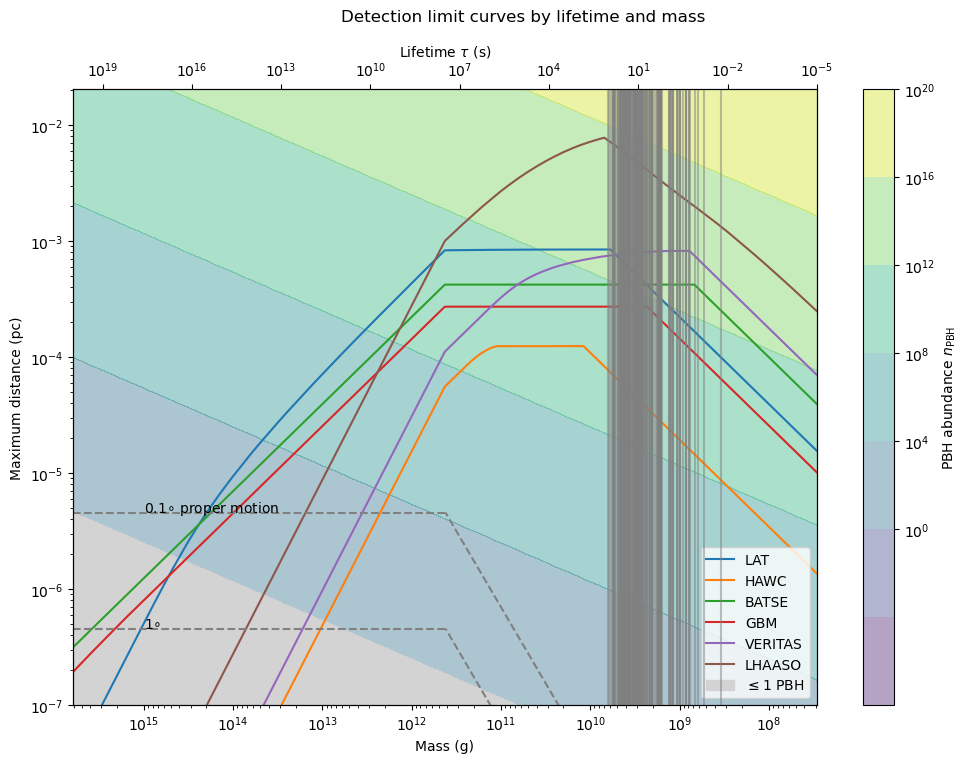

In [806]:
#### GRB GBM Catalog Sources

grbs = pd.read_csv('../GBM_Catalog_Searching/selectedGBMCatalogGRBs.csv')

ax2.errorbar(x = grbs['T90'], xerr = grbs['T90_ERROR'],
        y = grbs['DISTANCE'], yerr = grbs['DISTANCE_ERROR'],
        fmt = 'x', color='grey', markeredgecolor = 'C3', alpha=.5, zorder = 1)
    
    
ax2.scatter(grbs['T90'], grbs['DISTANCE'], marker = 'x', color = 'gold', zorder = 3)
fig

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


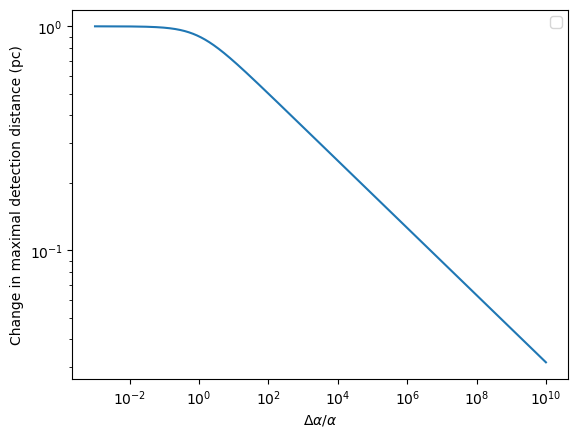

In [426]:
fig, ax = plt.subplots()

d_alpha = np.logspace(-3,10,1_000)

scale = lambda initial_d, d_alpha, beta = -.3 : np.sqrt((1+d_alpha)**beta) * initial_d

# for detector in EffectiveAreas:
ax.loglog(d_alpha, scale(1, d_alpha))
    # ax.scatter(d_alpha[0],distlim[detector], zorder = 1, alpha = .7)
ax.set_ylabel('Change in maximal detection distance (pc)')
ax.set_xlabel(r'$\Delta\alpha/\alpha$')
# ax.set_yscale('log')
ax.legend()

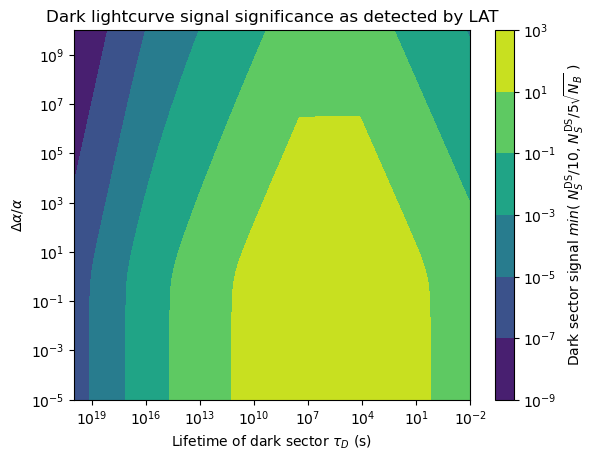

In [427]:
fig, ax = plt.subplots()

# detN is unscaled by distance
# Here's the play: we calculate N_S/10 and N_S/N_B/5, scaled by distance 1e-3pc
# Then we find the min of either -- anything >1 is then detectable to that sigma
# Contour that for variations in alpha and tau
d_alpha = np.logspace(-5, 10, 1_000)
remaining_lifetime = np.logspace(-2, 20, 1_000)
beta = -.3
distance = 1e-4 *u.pc.to('cm')


# Detector info
detector = 'LAT'
Erange = np.logspace(Eranges[detector][0], Eranges[detector][1])
Om = dOm[detector]
Aeff = interp1d( x = EffectiveAreas[detector]['E GeV'], y = EffectiveAreas[detector]['Aeff cm2'], kind='linear', bounds_error = False, fill_value = 0. )
tmin = remaining_lifetime[0]

dark_signal_mesh = []
# signal_mesh = []
for tau in remaining_lifetime:
    
    # Either obs duration or remaining lifetime
    obs_time = min(3e7, tau)

    # Calculate signal in dark sector case
    N = detN(Erange, tau, Aeff, Om, obs_time, tmin) / (4 * 3.14159 * distance**2)
    darkN = (1+d_alpha)**beta * N
    darkNs = detSN(darkN, Erange, Aeff, Om, obs_time, gamma_had_sep['LAT'])
    # darkNs = (1+d_alpha)**beta * Ns

    # Choose mins for sigmas
    dark_signal_mesh.append( [min(
        darkN[i] / 10,
        darkNs[i] / 5
        ) for i,_ in enumerate(darkN) ] )

    # signal_mesh.append( 
    #     [min(
    #         N[i] / 10,
    #         Ns[i] / 5
    #     ) for i,_ in enumerate(N) ] )

# signal_mesh = np.array(signal_mesh)
dark_signal_mesh = np.array(dark_signal_mesh)

d_alpha, remaining_lifetime = np.meshgrid(d_alpha, remaining_lifetime)

levels = np.arange(-9, 5, 2)

im = ax.contourf(remaining_lifetime, d_alpha, np.log10(dark_signal_mesh), levels = levels)
cb = fig.colorbar(im, label = r'Dark sector signal $min$( $N^{\rm{DS}}_S/10$, $N^{\rm{DS}}_S/5\sqrt{N_B}$ )', ticks = levels)
cb.ax.set_yticklabels( [r'$10^{%.f}$'%t for t in levels]  )

# im = axes[1].contourf(remaining_lifetime, d_alpha, signal_mesh)
# cb = fig.colorbar(im, label = r'Signal min( $N_S/10$, $N_S/5\sqrt{N_B}$ )')

# for ax in axes:
ax.set_ylabel(r'$\Delta\alpha/\alpha$')
ax.set_xlabel(r'Lifetime of dark sector $\tau_D$ (s)')
ax.set_xlim(ax.get_xlim()[1], ax.get_xlim()[0])
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_title('Dark lightcurve signal significance as detected by LAT')

fig.savefig('N_S_vs_alpha_D.png')

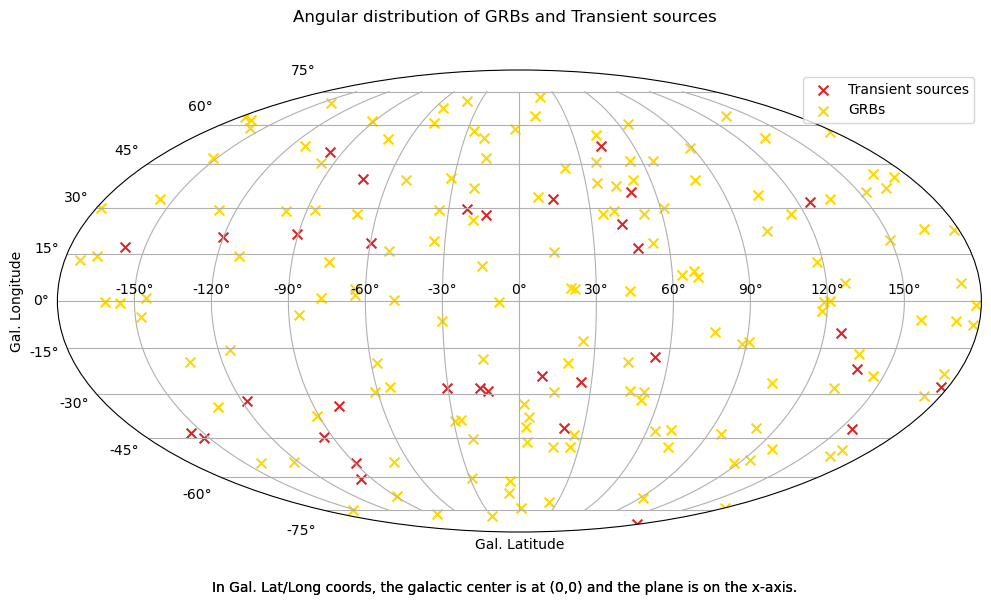

In [751]:
transients = pd.read_csv('../TransientLATSources/TransientSources_fitted_params.csv')
targets = transients.dropna()
grbs = pd.read_csv('../GBM_Catalog_Searching/selectedGBMCatalogGRBs.csv')


fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(111, projection='mollweide')
plt.grid(True)

grbs['LII'] = grbs['LII_x']
grbs['BII'] = grbs['BII_x']

colors = ('C3', 'gold')
labels = ('Transient sources', 'GRBs')

for i,modified in enumerate([targets.copy(), grbs.copy()]):
    
    modified.loc[modified['LII']>180, 'LII'] -= (360)
    
    ax.scatter(modified['LII']*(np.pi/180), modified['BII']*(np.pi/180), 50, marker = 'x', color = colors[i], label = labels[i])

    ax.set_ylabel('Gal. Longitude')
    ax.set_xlabel('Gal. Latitude')

    caption = 'In Gal. Lat/Long coords, the galactic center is at (0,0) and the plane is on the x-axis.'

    plt.figtext(0.5, 0.01, 
                caption, 
                horizontalalignment='center', fontsize=10)
    
ax.legend()
fig.suptitle('Angular distribution of GRBs and Transient sources')

# fig.suptitle('All unassociated transient sources')
fig.savefig('GRB_and_transients_source_dist.png')

In [644]:
import glob

# Collect files
datasets = glob.glob('../TransientLATSources/correct_unassociated/apjsac*.csv')

# Track SRCNumber
filename = []
filenumber = []

library = {} # key = filename, val = pd.DataFrame
for file in datasets:
    # Read in data for each file
    library['.%s'%file[22:]] = pd.read_csv(file, header=None)
    
    # Track SRCNumber
    filename.append(file)
    filenumber.append( int(file.split('_')[2]) )

# Reformat datasets
def reformat_datasets(library):
    reformat = {}

    for key in library:

        # For each dataset
        d = library[key]
        x = []
        y = []
        yerr = []
        # For each row
        for i in range(d.shape[0]):
            # Odds are data, evens are upper/lower error bound
            if i % 2:
                yerr.append(d.iloc[i,1])
            else:ß
                x.append(d.iloc[i,0])
                y.append(d.iloc[i,1])

        # Make error always positive
        yerr = np.abs(np.array(y) - np.array(yerr))

        # Reformat pd appropriately
        reformat[key] = pd.DataFrame( {'MJD':x, 'Fl (E>100MeV)e-8 cm-2 s-1':y, 'Error':yerr} )

    return reformat

library = reformat_datasets(library)

In [814]:
# This is MJD where 54500 = Aug 4 15:43:36 UTC, 2008 -- we can constrain to day-precision 
# Let's MJD as an MET
targets['Start MET (MJD)'] = [ library[filename]['MJD'].iloc[0] - 54500 for filename in targets['filename'] ]
targets['End MET (MJD)'] = [ library[filename]['MJD'].iloc[-1] - 54500 for filename in targets['filename'] ]
# targets['Start sec'] = targets['Start MJD'] * 86400
# targets['End sec'] = targets['End MJD'] * 86400

# Then the GBM Catalog names are yymmdd for 2000-yy so we can definitely track to day-precision
def breakdown_GRBName_to_s(NAME):
    year = (int(NAME[5:7]) - 8) * 365 # yr - 2008
    month = (int(NAME[7:9]) - 8) * 30.42 # mo. - 8 (Aug)
    days = year + month + int(NAME[9:11]) - 4 # 4th of Aug
    return days
    
grbs['Burst MET (MJD)'] = grbs['NAME_x'].apply(breakdown_GRBName_to_s)

/Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


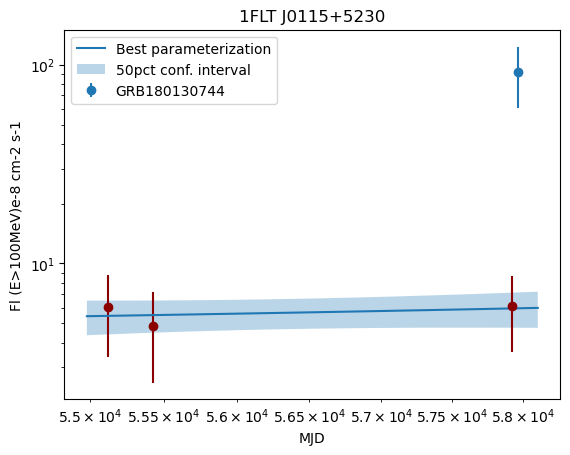

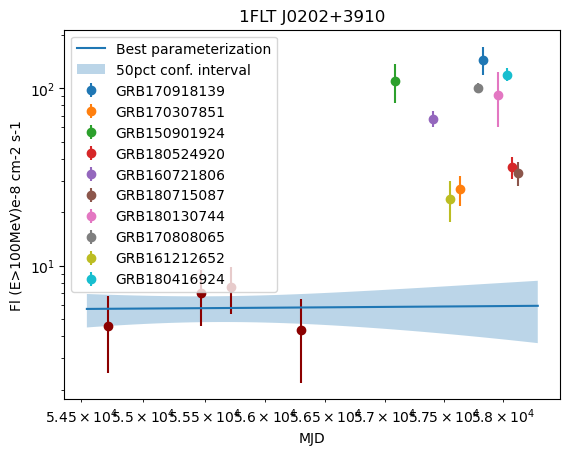

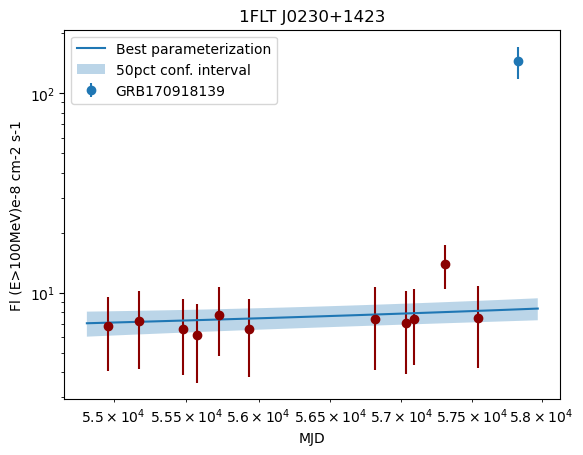

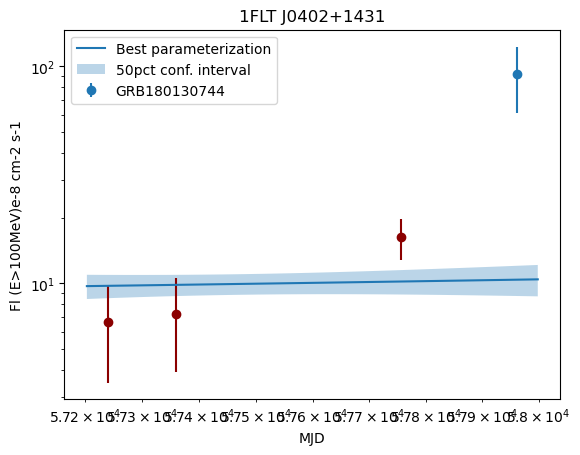

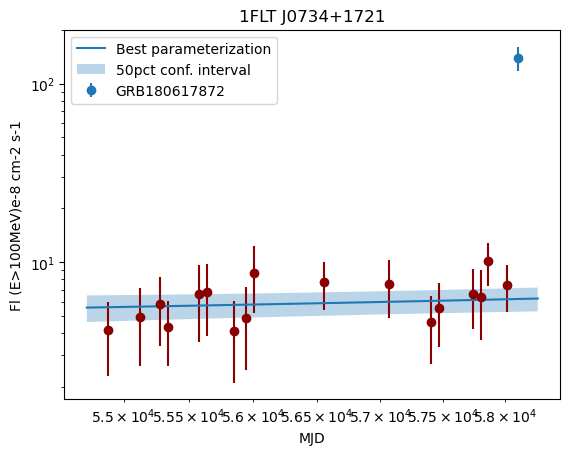

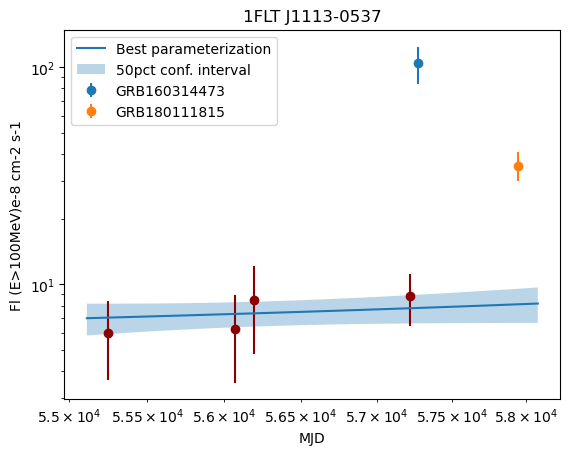

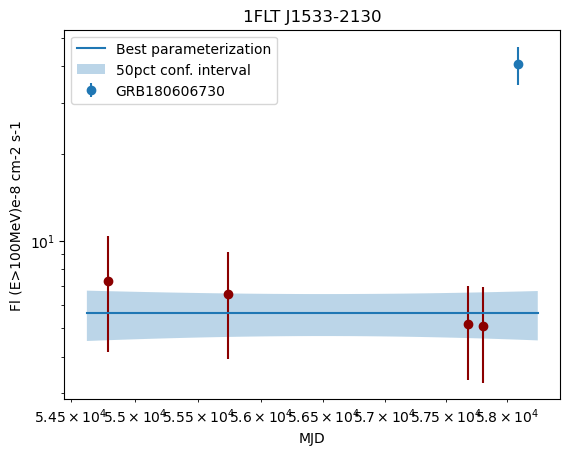

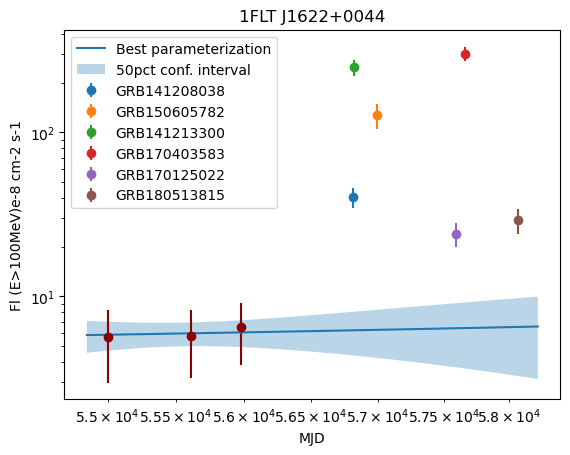

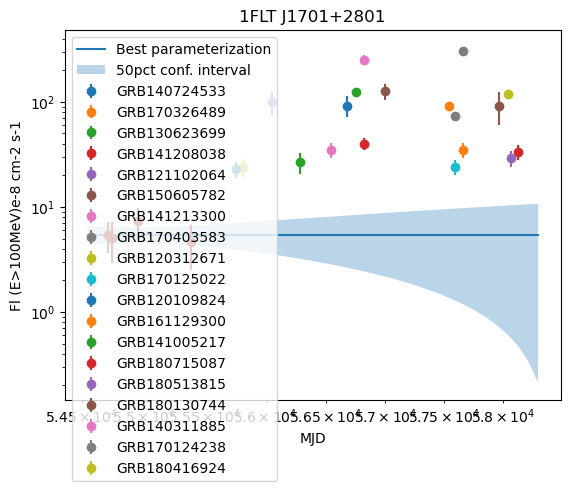

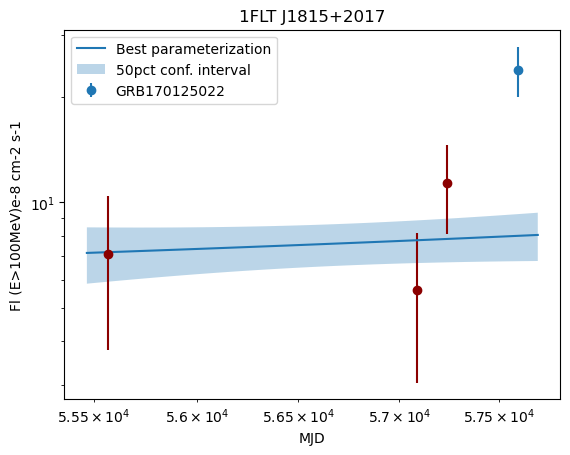

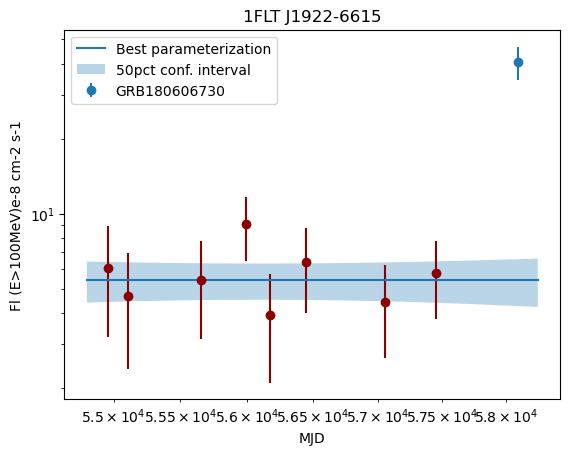

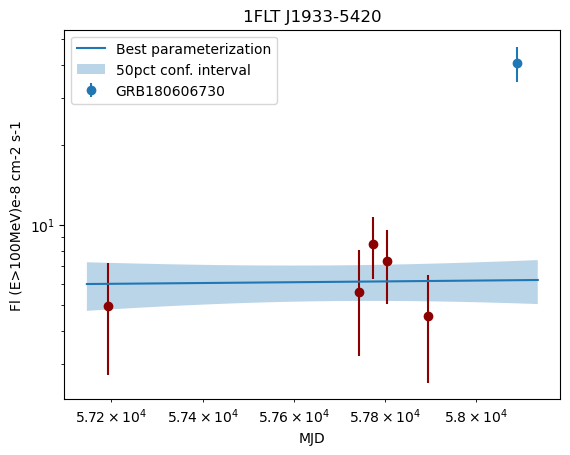

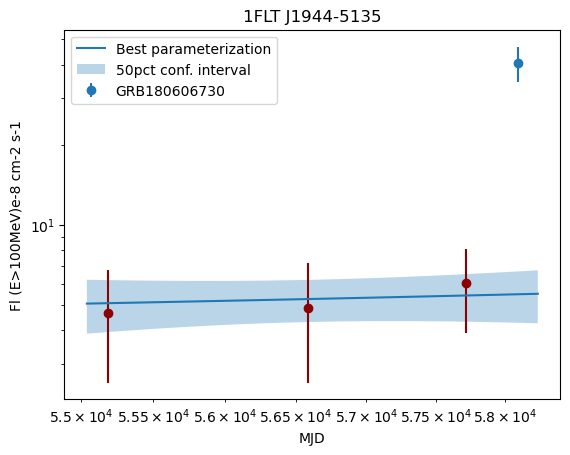

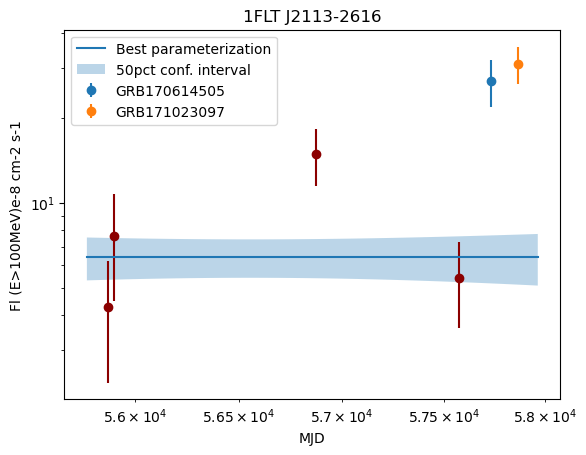

In [821]:
from scipy import stats
def propagate_error(a, b, e_a, e_b):
    return np.abs(a/b) * np.sqrt( (e_a/a)**2 + (e_b/b) )

model = lambda x,A,T0: 10**A * ((10**T0) - x)**(-.53) # T0 in MJD!!

degs_per_year = 10

associated = {}

for i in range(len(targets)):
    t = targets.iloc[i]

    grbs_in_ROI = []

    for j in range(len(selected)):
        s = selected.iloc[j]
        dt = s['Burst MET (MJD)'] - t['End MET (MJD)'] # Diff from last transient detection to burst detection
        if (
            dt >= 0# Burst time > last detected transient time
            and
            np.sqrt((t['LII'] - s['LII_x'])**2 + (t['BII'] - s['BII_x'])**2) - (s['ERROR_RADIUS_x'] + t['SEMI_MAJOR_AXIS']/60) < degs_per_year*(dt/365) # 1 deg/yr after last detection
            ): 
            grbs_in_ROI.append(s['NAME_x'])
    
    if len(grbs_in_ROI) > 0: associated[t['filename']] = grbs_in_ROI



for source in associated:

    fig, ax = plt.subplots()

    # Plot transient lightcurve
    x = library[source]['MJD']
    y = library[source]['Fl (E>100MeV)e-8 cm-2 s-1']
    yerr = library[source]['Error']
    
    ax.errorbar(x = x, y = y, yerr = yerr,
        fmt='o', color = 'darkred')

    # Plot individual GRBs in ROI
    for name in associated[source]:
        grb = selected.query('NAME_x == @name')
        ax.errorbar(
            x = grb['Burst MET (MJD)'] + 54500,
            y = grb['PFLX_PLAW_ERGFLUX']*1e8,
            yerr = grb['PFLX_PLAW_ERGFLUX_ERROR']*1e8,
            fmt = 'o',
            label = name[2:-1])

    # Plot fitted model
    t = transients.query('filename == @source').iloc[0]
    coefs = (np.log10(t['norm']), np.log10(t['T0']))
    xaxis = np.linspace(*ax.get_xlim())
    y_model = model(xaxis, *coefs)
    ax.plot(xaxis, y_model, color = 'C0', label = 'Best parameterization')

    # Settings
    ax.set_title(t['NAME'][2:-1])
    ax.set_xlabel('MJD')
    ax.set_ylabel('Fl (E>100MeV)e-8 cm-2 s-1')

    
    s_err = np.mean(
        [ 1 - stats.norm.pdf(ydata, loc=y[k], scale=yerr[k]) for k, ydata in enumerate(model(x, *coefs)) ]
        )

    n = len(y)
    y_fit_upper = y_model + s_err * np.sqrt(1.0 + 1.0/n + (xaxis - np.mean(x))**2 / np.sum((x - np.mean(x))**2))
    y_fit_lower = y_model - s_err * np.sqrt(1.0 + 1.0/n + (xaxis - np.mean(x))**2 / np.sum((x - np.mean(x))**2))


    # bounds = []
    # for a in [t['norm_min'], t['norm_max']]:
    #     for b in [t['T0_min'], t['T0_max']]:
    #         bounds.append(model(xaxis, np.log10(a), np.log10(b)))
    # bounds = np.vstack(bounds)
    # y_fit_lower = bounds.min(axis=0)
    # y_fit_upper = bounds.max(axis=0)

    
    ax.fill_between(xaxis, y_fit_lower, y_fit_upper, alpha=0.3, label='50pct conf. interval')

    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.legend()
        

# associated